"""
The notebook outlines an implementation of a hierarchical reinforcement learning (HRL) environment and agent specifically designed for search and rescue (SAR) scenarios. The goal of this system is to efficiently manage and solve complex, multi-step tasks by breaking them down into simpler subtasks (options), each with its own set of actions. The system integrates language processing and environmental interaction capabilities, making it suitable for dynamic and information-rich environments like disaster sites.

### Core Components and Their Roles:

1. **SARenvHRL Class**:
   - **Environment Setup**: This class sets up the SAR environment with elements like grid size, start and final states, hazards (fires, ditches), points of interest (POIs), and penalties/rewards for different actions. It configures the environment based on the provided parameters and initializes various states and metrics used during the simulation.
   - **State Management**: Manages the state of the agent within the grid, including position and whether specific information has been collected or victims have been saved.
   - **Action Handling**: Defines the possible actions and how these actions impact the agent's state, including movement and interaction with the environment (collecting information, saving victims).
   - **Reward Calculation**: Implements the logic to compute rewards based on the agent's actions and their outcomes, providing feedback necessary for learning.

2. **DisasterResponseAssistant Class**:
   - **Information Processing**: Utilises a document loader to read and process documents relevant to the SAR operation, potentially to simulate obtaining actionable intelligence from field reports or databases.
   - **Response Generation**: Uses a language model (ChatOllama) and vector storage to analyze verbal inputs and generate responses. This simulates receiving and processing verbal data from search and rescue teams or impacted humans (here).

3. **HierarchicalQLearningAgent_ATTENTION Class**:
   - **Hierarchical Learning**: Manages a two-level Q-learning approach where high-level actions (options) and low-level actions (primitive actions) are learned simultaneously. High-level actions could be strategic decisions like choosing to explore or collect information, while low-level actions would be specific movements or operations.
   - **Attention Mechanism**: Implements an attention mechanism to dynamically adjust the learning focus based on changes in the environment, detected through sensor readings. This can help the agent adapt its strategy based on real-time feedback from the environment.
   - **Decision Making**: Controls the selection and execution of actions based on learned Q-values, adjusted by the attention mechanism. It supports exploration and exploitation strategies to balance learning new information with leveraging known information for effective decision-making.

### Goals and Strategies:

- **Efficient Task Completion**: By breaking down tasks into manageable subtasks (options) and learning the best strategies for each, the system aims to complete search and rescue missions efficiently.
- **Adaptation and Learning**: The system adapts to the changing environment by updating its strategy based on new information, aiming to improve its performance over time through reinforcement learning.
- **Integration of Verbal and Environmental Data**: By processing both environmental data (like sensor readings) and verbal inputs (like reports of hazards or points of interest), the system combines multiple data sources to enhance its understanding and decision-making capabilities.

### Application:

This system could be used in real-world SAR operations where both environmental awareness and rapid adaptation to new information are crucial. The integration of language processing allows the agent to leverage verbal reports and written data, enhancing its operational capabilities in complex and dynamic scenarios. The hierarchical learning approach ensures that learning is both deep (detailed strategies for specific actions) and broad (overall strategies for achieving goals), suitable for the multifaceted challenges of SAR missions.
"""

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm.auto import tqdm
import pandas as pd
from IPython.display import clear_output
import time
from PIL import Image
from io import BytesIO
import torch
from termcolor import colored
import os

In [2]:
import json
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.vectorstores import Chroma
from langchain_community import embeddings
from langchain_community.chat_models import ChatOllama
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain.output_parsers import PydanticOutputParser
from langchain.text_splitter import CharacterTextSplitter
from langchain_experimental.llms.ollama_functions import OllamaFunctions
from langchain_community.document_loaders import JSONLoader
from pprint import pprint
#from utils_functions import get_file_type

### class that processes verbal inputs handle disaster-related verbal inputs, analyze them using RAG architecture, and generate a 
# response in a specified format. It leverages models like ChatOllama and techniques like vector storage and retrieval for its operations.
class DisasterResponseAssistant:
    def __init__(self, data_path, data_type, model_name="mistral", embedding_model='nomic-embed-text', collection_name="rag-chroma"):
        self.model_name = model_name
        self.embedding_model = embedding_model
        self.collection_name = collection_name
        self.data_path = data_path
        self.data_type = data_type
        
        self.llm = None
        self.loader = None
        self.vectorstore = None
        self.retriever = None
        
        self._load_model()            # Initializes an instance of the ChatOllama model    
        self._load_documents()        # Loads and splits the PDF document into chunks
        self._create_vectorstore()    # Creates a vector store using Chroma from the document splits
        self._create_retriever()      # Creates a retriever from the vector store
        
        self.hazard_coordinates = []  # To store hazard coordinates
        self.poi_coordinates = []     # To store points of interest coordinates
    
    def _load_model(self):
        self.llm = ChatOllama(model=self.model_name)
        

    def _load_documents(self): ## for json documents
        print(f"document {self.data_type} will be infused")
        if self.data_type == 'pdf':
            self.loader = PyPDFLoader(self.data_path)
            self.data = self.loader.load_and_split()
        elif self.data_type == 'json':
            self.loader = JSONLoader(
                file_path=self.data_path,
                jq_schema='.',
                text_content=False)
            self.data = self.loader.load()
            #pprint(self.data)
        else:
            raise ValueError("Unsupported document type. Please choose either 'pdf' or 'json'.")


    def _create_vectorstore(self): ## for json documents
        self.vectorstore = Chroma.from_documents(
            documents=self.data,
            collection_name=self.collection_name,
            embedding=embeddings.OllamaEmbeddings(model=self.embedding_model),
        )

        
    def _create_retriever(self):
        self.retriever = self.vectorstore.as_retriever()

    ### generate a response based on a verbal input
    ### construct a template for the response using RAG architecture
    def generate_response(self, verbal_input):
        prompt_template = """You are an assistant, who carefully listens to verbal inputs: {verbal_input} and specialized in analyzing disaster-related inputs. Your task is 
to identify physical locations mentioned in the text and classify them as either points of interest (POI) or as hazards/dangers (HAZARD) for rescue operations. Use the
information provided in the documents: {context}, such as KEYWORDS, descriptions and context when locations are mentioned, to make your classification.
Output the classification in the form of a JSON array dictionary with keys 'location', 'coordinates', and 'category'. Here are some rules you always follow:
- Focus strictly on physical locations. Avoid including entities that do not represent physical, geographical places (such as individuals, conditions, or 
  abstract concepts).
- Generate human-readable output in the specified dictionary format.
- Generate only the requested output, strictly following the dictionary structure.
- Within the dictionary, the value of the `category` key must be either 'POI' or 'HAZARD'. 
- Never generate offensive or foul language.
- Never give explanations over your output.
Input: {verbal_input}
"""
        system_template = ChatPromptTemplate.from_template(prompt_template)
        output_parser = StrOutputParser()
        after_rag_chain = (
            {"context": self.retriever, "verbal_input": RunnablePassthrough()}
            | system_template
            | self.llm  # Assuming model_local is defined elsewhere and accessible
            | output_parser
        )
        response = after_rag_chain.invoke(verbal_input)
        return response
    
    def refine_response(self, output):
        cleaned_output_str = output.strip().replace('\n', '').replace('(', '[').replace(')', ']')
        output_dict = json.loads(cleaned_output_str)

        for item in output_dict:
            coord = tuple(item['coordinates'])
            if item['category'] == 'HAZARD':
                self.hazard_coordinates.append(coord)
            else:
                self.poi_coordinates.append(coord)
                    
        print("Hazardous Coordinates:", self.hazard_coordinates)
        print("Point of Interest Coordinates:", self.poi_coordinates)
        return self.hazard_coordinates, self.poi_coordinates

In [161]:
class SARenvHRL:
    def __init__(self, gridsize, startState, finalState, ditches, fires, POIs, infoLocation, image_path, document_path, mode='prod'):
        self.gridsize = gridsize
        self.startState = startState
        self.finalState = finalState
        self.ditches = ditches
        self.infoLocation = infoLocation
        self.fires = fires
        self.POIs = POIs
        
        self.maxSteps = 2 * (self.gridsize[0] * self.gridsize[1])  # max steps needed for NAVIGATION -- EXPLORE
        self.ditchPenalty = -10
        self.turnPenalty = -1
        #self.savePenalty = -10
        self.exceedStepPenalty = -1
        self.wrongCollectPenalty = -5
        self.winReward = 100
    
        self.mode = mode
        
        self.desired_cell_size = 50  # The size of cells in the grid for visualization
        self.generate_annotated_image(image_path)
        
        self.actionspace = {'EXPLORE': ['up', 'down', 'left', 'right'], 
                     'COLLECT': ['get X', 'get Y', 'get Z'],
                     'SAVE': ['save']}
        self.optionspace = ['EXPLORE', 'COLLECT', 'SAVE']

        
        self.visited_information_state = False
        self.isGameEnd = False
        self.info_collectedX = False
        self.info_collectedY = False
        self.info_collectedZ = False
        self.totalTurns = 0
        self.totalAsks = 0
        self.totalSaves = 0
        self.victim_saved = False
        self.correct_sequence = ['X']
        
        self.collected_info = []
        self.ask_action_counter = 0
        
        # self.document_type = self.get_file_type(document_path)
        # self.assistant = DisasterResponseAssistant(document_path, self.document_type)
        self.ask_action_counter = 0
        self.hazards = []
        self.pois = []
        self.sensor_readings = {}
        
    
        self.current_state = (self.startState[0], self.info_collectedX, self.info_collectedY, self.info_collectedZ, self.victim_saved)
        if self.mode == 'debug':
            print("Initialization complete.")
        
        
        self.keywords_for_POIs = ["victim", "trail", "potential sighting", "Screams", "shelter", "high ground", "water source",
                                  "access route", "last known position", "high probability area", "safe"]
        self.keywords_for_danger = ["fire", "heat", "smoke", "restricted", "no access allowed", "flames", "dangerous", "steep terrain",
                                    "dense vegetation", "unstable structures", "unstable buildings", "hazardous material", "unsafe"]

        self.locationsDict = {
            'hospital': (0, 3),
            'train station': (5, 6),
            'school': (2, 0),
            'mall': (3, 0),
            'bank': (2, 5),
            'restaurant': (6, 5),
            'shop': (1, 1)
        }
    
    def reset(self):
        self.correct_sequence = ['X']
        self.visited_information_state = False
        self.collected_info = []
        self.info_collectedX, self.info_collectedY, self.info_collectedZ = False, False, False
        self.victim_saved = False
        self.isGameEnd = False
        self.totalTurns = 0
        self.totalAsks = 0
        self.totalSaves = 0
        self.position = self.startState[0]
        self.current_state = (self.position, self.info_collectedX, self.info_collectedY, self.info_collectedZ, self.victim_saved)
        return self.current_state
    
    def get_file_type(self, docs_path):
        # Split the path and get the extension
        _, file_extension = os.path.splitext(docs_path)
        # Return the file extension without the period
        return file_extension[1:] if file_extension else None

    ##### ----------------------------
    
    def next_state_vision(self, target_state, action):  ### here just movement, thus just EXPLORE option
        position = target_state
        next_position = position
        # Movement actions update
        if action == self.actionspace[self.optionspace[0]][0] and position[0] > 0:  # up
            next_position = (position[0] - 1, position[1])
        elif action == self.actionspace[self.optionspace[0]][1] and position[0] < self.gridsize[0] - 1:  # down
            next_position = (position[0] + 1, position[1])
        elif action == self.actionspace[self.optionspace[0]][2] and position[1] > 0:  # left
            next_position = (position[0], position[1] - 1)
        elif action == self.actionspace[self.optionspace[0]][3] and position[1] < self.gridsize[1] - 1:  # right
            next_position = (position[0], position[1] + 1)
        return (next_position)
    
    
    def ask_action(self, state):
        self.ask_action_counter += 1
        position, info_collectedX, info_collectedY, info_collectedZ, victim_saved = state
        verbal_inputs = []
        if not info_collectedX:
            
            # VERBAL_INPUT1 = "Hey, there's a victim at the hospital."
            # VERBAL_INPUT2 = "Watch out, fire was reported next to the mall."#. There's a shelter through the bank and the train station."
            # #VERBAL_INPUT3 = "Someone told me about Screams heard at the shop and close to restaurant."
            # verbal_inputs.append(VERBAL_INPUT1)
            # verbal_inputs.append(VERBAL_INPUT2)
            # #verbal_inputs.append(VERBAL_INPUT3)
            
            VERBAL_INPUT1 = "Hey, there's a victim at the hospital."
            VERBAL_INPUT2 = "Watch out, there is a shelter though the mall. Also, fire was reported at the restaurant."
            VERBAL_INPUT3 = "Someone told me about Screams heard at the shop."
            verbal_inputs.append(VERBAL_INPUT1)
            verbal_inputs.append(VERBAL_INPUT2)
            verbal_inputs.append(VERBAL_INPUT3)
            for input_text in verbal_inputs:
                    self.simulate_LLM_process_alternative(input_text)
    
    
    
            
            
            # VERBAL_INPUT1 = "Hey, there's a victim at the hospital and I think I also saw fire in the train station." #and the bank. Hey, you wait! Someone told me about screams heard at the school and close to the mall. Hurry!"
            # verbal_inputs.append(VERBAL_INPUT1)
            # if self.ask_action_counter <= 1:
            #     print(f"real LLM is about to start handling the input {VERBAL_INPUT1}")
            #     for input_text in verbal_inputs:
            #         response = self.assistant.generate_response(input_text)
            #         if response:
            #             self.visited_information_state = True
            #         self.hazards, self.pois = self.assistant.refine_response(response)
            #         print(f"real LLM is about to end handling the input {VERBAL_INPUT1}")
            #         self.update_environment_REAL(self.hazards, self.pois)
            # else:
            #     #print(f"input will be handled hereby by pseudoLLM")
            #     #print(self.hazards, self.pois)
            #     self.visited_information_state = True
            #     self.update_environment_REAL(self.hazards, self.pois)
            #     # for input_text in verbal_inputs:
            #     #     self.simulate_LLM_process_alternative(input_text)
    
    # def update_environment_REAL(self, haz, poi):
    #     for hazardous_location in haz:
    #         self.sensor_readings[(hazardous_location, True, False, False)] = -10.0
    #         #self.sensor_readings[(hazardous_location, True)] = -10.0
    #         self.fires.append(hazardous_location)
    #     for safe_location in poi:
    #         self.sensor_readings[(safe_location, True, False, False)] = 10.0
    #         #self.sensor_readings[(safe_location, True)] = 10.0
    #         self.POIs.append(safe_location)
        
    
    ### Simulates the process of obtaining information from a language model (multiple locations)
    ### problem when two locations associated to different class are present in the smae sentence 
    def simulate_LLM_process_alternative(self, input):
        sum_embedding = torch.tensor([0, 0], dtype=torch.float32)
        locations_in_input = []
        for location in self.locationsDict:
            # Check if the location keyword is in the information string
            if location in input:
                location_embedding = torch.tensor(self.locationsDict[location], dtype=torch.float32)
                sum_embedding += location_embedding
                locations_in_input.append(tuple(int(x) for x in location_embedding.tolist()))
        #return locations_in_input
        if locations_in_input:
            #print(f"response is {locations_in_input} -- when input is: {input}")
            self.visited_information_state = True
            #print(f"response is {response}")
            sentences = input.split(". ") if ". " in input else [input]
            #print(f"the sentences are: {sentences}")
            for sentence in sentences:
                is_poi = any(keyword in sentence for keyword in self.keywords_for_POIs)
                is_fire = any(keyword in sentence for keyword in self.keywords_for_danger)
                #print(f"In sentence '{sentence}' we have POI: {is_poi} and fire: {is_fire}")
                for location, location_coords in self.locationsDict.items():
                    if location in sentence:
                        info = tuple(int(x) for x in torch.tensor(location_coords, dtype=torch.float32).tolist())
                        #print(f"info now is {info} and poi {is_poi} and fire {is_fire}")
                        # If the location is already categorized, skip it
                        if info in self.POIs or info in self.fires:
                            continue
                        # Add location to POIs or fires based on the context of the sentence
                        self.update_environment(info, is_poi, is_fire)
    
    def update_environment(self, info, is_poi, is_fire):
        if is_poi and not is_fire:
            self.sensor_readings[(info, True, False, False, False)] = 10.0
            self.POIs.append(info)
        elif is_fire and not is_poi:
            self.sensor_readings[(info, True, False, False, False)] = -10.0
            self.fires.append(info)
                   
    
    ##### does not take into account the order of the info collection (WORKS)
    def step(self, action, option):
        position, info_collectedX, info_collectedY, info_collectedZ, victim_saved = self.current_state  # Unpack the current state        
        option_terminated = False
        fell_into_ditch = False
        next_position = position
    
        if option == self.optionspace[0]:  ### EXPLORE
            if action in self.actionspace[self.optionspace[0]]:   ### ['up', 'down', 'left', 'right']
                self.totalTurns += 1
                # Movement actions update
                if action == self.actionspace[self.optionspace[0]][0] and position[0] > 0:  # up
                    next_position = (position[0] - 1, position[1])
                elif action == self.actionspace[self.optionspace[0]][1] and position[0] < self.gridsize[0] - 1:  # down
                    next_position = (position[0] + 1, position[1])
                elif action == self.actionspace[self.optionspace[0]][2] and position[1] > 0:  # left
                    next_position = (position[0], position[1] - 1)
                elif action == self.actionspace[self.optionspace[0]][3] and position[1] < self.gridsize[1] - 1:  # right
                    next_position = (position[0], position[1] + 1)
            # Check if information is collected or if the agent fell into a ditch
            if (next_position == self.infoLocation[0] and not info_collectedX) or \
                (next_position == self.infoLocation[1] and not info_collectedY) or \
                (next_position == self.infoLocation[2] and not info_collectedZ):
                    option_terminated = True
            
            if next_position == self.finalState[0] and info_collectedX and not victim_saved:
                option_terminated = True
            
            if self.totalTurns > self.maxSteps or next_position in self.ditches:
                option_terminated = True
                fell_into_ditch = next_position in self.ditches  # Agent fell into a ditch if true

        elif option == self.optionspace[1]:  ### COLLECT
            # Ask actions update
            if action in self.actionspace[self.optionspace[1]]:  ### ['get X', 'get Y', 'get Z']
                # Ask actions update
                self.totalAsks += 1
                info_type = action.split(' ')[1]  # Extract the type of information being collected ('X', 'Y', 'Z')
                if position == self.infoLocation[0] and info_type == 'X':
                    self.ask_action(self.current_state)
                    info_collectedX = True
                    self.collected_info.append(info_type)
                    option_terminated = True
                elif position == self.infoLocation[1] and info_type == 'Y':
                    info_collectedY = True
                    self.collected_info.append(info_type)
                    option_terminated = True
                elif position == self.infoLocation[2] and info_type == 'Z':
                    info_collectedZ = True
                    self.collected_info.append(info_type)
                    option_terminated = True
                else:
                    # If the agent is not at the correct location or the info is out of sequence,
                    # the option is terminated.
                    option_terminated = True
                    
        elif option == self.optionspace[2]:   ### SAVE 
            if action in self.actionspace[self.optionspace[2]]: ### ['save']
                if position == self.finalState[0] and info_collectedX:
                    # Assuming saving is only contingent on collecting information X for simplicity
                    victim_saved = True
                    option_terminated = True
                else:
                    #reward = self.wrongCollectPenalty  # Or another penalty as appropriate
                    option_terminated = True
        
        
        # Check if all information has been collected in the correct sequence
        all_info_collected_in_correct_order = self.collected_info == self.correct_sequence
        #done = next_position == self.finalState[0] and all_info_collected_in_correct_order
        done = position == self.finalState[0] and victim_saved and all_info_collected_in_correct_order
        reward = self.calculate_reward(position, next_position, done, option, fell_into_ditch)
        ditch_event = fell_into_ditch  # Set ditch_event based on whether the agent fell into a ditch
        # Reset the agent's position to the start state if it fell into a ditch
        if fell_into_ditch:
            next_position = self.startState[0]  ## an xtupisw empodio to option kanei terminate alla oxi to epeisodio
        
        self.current_state = (next_position, info_collectedX, info_collectedY, info_collectedZ, victim_saved)
        return self.current_state, reward, done, option_terminated, ditch_event

    def calculate_reward(self, position, next_position, done, current_option, fell_into_ditch):
        if fell_into_ditch:
            return self.ditchPenalty
        elif done:
            return self.winReward
        elif self.totalTurns > self.maxSteps:
            return self.exceedStepPenalty
        elif current_option == self.optionspace[1] and not self.is_sequence_correct():
            return self.wrongCollectPenalty  # Assume you have defined this penalty value in the initializer
        elif current_option == self.optionspace[2] and not self.is_sequence_correct():
            return self.wrongCollectPenalty
        else:
            return self.turnPenalty
    
    def is_sequence_correct(self):
        return self.collected_info == self.correct_sequence[:len(self.collected_info)]

    
    # def calculate_discrepancy(self, collected_info):
    #     # Initialize the discrepancy score
    #     discrepancy_score = 0
    #     # Create a mapping of element to its index in the optimal_sequence for order comparison
    #     optimal_indexes = {element: index for index, element in enumerate(list(self.ListB.keys()))}
    #     # Check for missing elements and add their weights to the discrepancy score
    #     for element in list(self.ListB.keys()):
    #         if element not in collected_info:
    #             discrepancy_score += self.ListB[element]
    #     # Check the order for elements in the estimated_sequence
    #     last_index = -1  # Initialize with an index that's before the first element's index
    #     for element in collected_info:
    #         if element in optimal_indexes:
    #             current_index = optimal_indexes[element]
    #             # If the current element is out of order, add its weight to the discrepancy score
    #             if current_index < last_index:
    #                 discrepancy_score += self.ListB[element]
    #             else:
    #                 # Update last_index to the current element's index if it's in correct order
    #                 last_index = current_index
    #     #print(discrepancy_score)
    #     return discrepancy_score
    
    

    ### Methods for annotating and generating images of the environment grid
    def annotate_cell(self, ax, row, col, text, color='white'):
        """ Annotates a specific cell in the grid with given text and color. """
        ax.text(col * self.desired_cell_size + self.desired_cell_size/2,
                row * self.desired_cell_size + self.desired_cell_size/2,
                text,
                ha='center',
                va='center',
                color=color,
                fontsize=15,
                weight='bold')
    
    
    def generate_annotated_image(self, image_path):
        # Load and process the image
        img = Image.open(image_path)
        # Resize and crop image to fit the grid
        aspect_ratio = img.width / img.height
        if aspect_ratio > 1:
            new_size = (self.gridsize[0] * img.height // self.gridsize[1], img.height)
        else:
            new_size = (img.width, self.gridsize[1] * img.width // self.gridsize[0])
        img = img.resize(new_size, Image.Resampling.LANCZOS)
        crop_x = (img.width - self.gridsize[0] * (img.height // self.gridsize[1])) // 2
        crop_y = (img.height - self.gridsize[1] * (img.width // self.gridsize[0])) // 2
        img = img.crop((crop_x, crop_y, img.width - crop_x, img.height - crop_y))
        # Resize image to have equal cells
        new_image_width = self.desired_cell_size * self.gridsize[0]
        new_image_height = self.desired_cell_size * self.gridsize[1]
        img = img.resize((new_image_width, new_image_height))
        # Create figure with annotations
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.imshow(img)
        # Draw grid lines in white
        ax.set_xticks([i * self.desired_cell_size for i in range(self.gridsize[0] + 1)], minor=False)
        ax.set_yticks([i * self.desired_cell_size for i in range(self.gridsize[1] + 1)], minor=False)
        ax.grid(which="both", color="white", linestyle='-', linewidth=2)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        # Add annotations for each cell
        for row in range(self.gridsize[1]):
            for col in range(self.gridsize[0]):
                cell_coord = (row, col)
                # Check for special states and annotate accordingly
                if cell_coord in self.startState:
                    self.annotate_cell(ax, row, col, 'START', color='coral')  # Start
                elif cell_coord in self.finalState:
                    self.annotate_cell(ax, row, col, 'VIC', color='cyan')  # Terminal
                elif cell_coord in self.ditches:
                    self.annotate_cell(ax, row, col, 'D', color='red')  # Ditch
                elif cell_coord in self.fires:
                    self.annotate_cell(ax, row, col, 'F', color='orange')  # Fire
                elif cell_coord in self.POIs:
                    self.annotate_cell(ax, row, col, 'P', color='purple')  # POI
                elif cell_coord in self.infoLocation:
                    self.annotate_cell(ax, row, col, 'INFO', color='yellow')  # Info
                else:
                    self.annotate_cell(ax, row, col, str(cell_coord))  # Regular cell coordinate
        # Save figure to buffer and load as PIL image
        buf = BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)
        self.annotated_image = Image.open(buf)
    
    ### Visualizes the current state of the environment.
    ### Visualizes the current state of the environment.
    def render(self):
        clear_output(wait=True)
        fig, ax = plt.subplots(figsize=(8, 8))#plt.subplots()
        ax.set_xlim(0, self.gridsize[0])
        ax.set_ylim(0, self.gridsize[1])
        ax.set_xticks(range(self.gridsize[0]))
        ax.set_yticks(range(self.gridsize[1]))
        ax.grid(which='both')
        # Plotting the agent
        #agent_pos, _, _ = self.currentState
        agent_pos = self.position
        ax.plot(agent_pos[1] + 0.5, agent_pos[0] + 0.5, 'o', color='blue', markersize=10)  # Agent as a blue dot
        # Plotting the ditches
        for ditch in self.ditches:
            ax.plot(ditch[1] + 0.5, ditch[0] + 0.5, 'x', color='red', markersize=10)
        # Plotting the terminal state (victim's location)
        for terminal in self.finalState:
            ax.plot(terminal[1] + 0.5, terminal[0] + 0.5, 'P', color='green', markersize=10)
        for poi in self.POIs:
            ax.plot(poi[1] + 0.5, poi[0] + 0.5, 'P', color='pink', markersize=10)
        for hazard in self.fires:
            ax.plot(hazard[1] + 0.5, hazard[0] + 0.5, 'x', color='orange', markersize=10)
        # Plotting the info location
        for info in self.infoLocation:
            ax.plot(info[1] + 0.5, info[0] + 0.5, '*', color='yellow', markersize=10)
        plt.gca().invert_yaxis()
        plt.show()


Initialization complete.


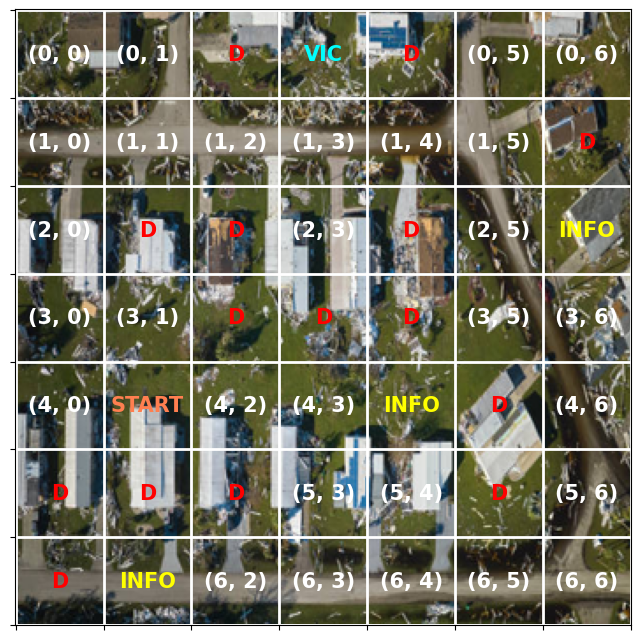

In [170]:
# Example initialization and training
gridsize = [7, 7]
startState = [(4, 1)]
victimStates = [(0, 3)]
ditches = [(1, 6), (2, 1), (2, 2), (2, 4), (3, 2), (3, 3), (3, 4), (4, 5), \
         (5, 0), (5, 1), (5, 2), (6, 0), (0, 2), (0, 4), (5, 5)]

#ditches = []
fires = []
POIs = []  # Victim locations
#infoLocation = [(6, 1), (4, 4), (2, 6)]  # Location to ask for information was (6, 1)
#infoLocation = {(6, 1): 'X', (4, 4): 'Y', (2, 6): 'Z'}
infoLocation = [(6, 1), (4, 4), (2, 6)]
fires = []
POIs = []

image_path = "/home/dimiubuntu/Desktop/local_code_scripts/enhanced_RL/enhanced_RL/images/disaster_area.jpg"
document_path = "/home/dimiubuntu/Desktop/local_code_scripts/enhanced_RL/enhanced_RL/data/sar_data.json"


env = SARenvHRL(gridsize, startState, victimStates, ditches, fires, POIs, infoLocation, image_path, document_path, mode='debug')

In [163]:
class HierarchicalQLearningAgent:
    def __init__(self, environment, actions, alpha, gamma):
        self.actions = actions
        self.env = environment
        self.alpha = alpha
        self.gamma = gamma
        self.high_level_q_table = {}  # Maps state -> option -> Q-value
        self.low_level_q_table = {}  # Maps (state, option, action) -> Q-value
        
    def _get_high_q_value(self, state, option):
        return self.high_level_q_table.get((state, option), 0)

    def _get_low_q_value(self, state, action):
        return self.low_level_q_table.get((state, action), 0)

    def select_option(self, state, exploration_rate):
        if random.random() < exploration_rate:
            return random.choice(list(self.actions.keys()))
        else:
            q_values = {option: self._get_high_q_value(state, option) for option in self.actions.keys()}
            return max(q_values, key=q_values.get)

    def select_action(self, state, option, exploration_rate):
        if random.random() < exploration_rate:
            return random.choice(self.actions[option])
        else:
            q_values = {(state, option, action): self._get_low_q_value((state, option), action) for action in self.actions[option]}
            return max(q_values, key=q_values.get)[2]

    def update(self, state, option, action, reward, next_state, done):
        # Update low-level Q-value
        current_q = self._get_low_q_value((state, option), action)
        next_max_q = max(self._get_low_q_value((next_state, option), a) for a in self.actions[option]) if not done else 0
        self.low_level_q_table[((state, option), action)] = current_q + self.alpha * (reward + self.gamma * next_max_q - current_q)

        # Update high-level Q-value
        current_option_q = self._get_high_q_value(state, option)
        next_max_option_q = max(self._get_high_q_value(next_state, o) for o in self.actions.keys()) if not done else 0
        self.high_level_q_table[(state, option)] = current_option_q + self.alpha * (reward + self.gamma * next_max_option_q - current_option_q)

    def execute_option(self, initial_state, option, exploration_rate, visit_counts):
        state = initial_state
        total_reward = 0
        done = False
        option_terminated = False ##
        self.env.totalTurns = 0
        self.env.totalAsks = 0
        self.env.totalSaves = 0
        
        while not done:
            action = self.select_action(state, option, exploration_rate)
            next_state, reward, done, option_terminated, ditch_event = self.env.step(action, option)
            if ditch_event:
                # Apply the penalty for the ditch event but reset the state for the next iteration
                self.update(state, option, action, reward, state, done)
                #print(f"O: {option} | {state} | a: {action} | s_: {next_state} | r: {reward}")
                state = self.env.reset()  # Reset to start state after applying penalty
            else:
                # Regular update when no ditch event
                self.update(state, option, action, reward, next_state, done)
                #print(f"O: {option} | {state} | a: {action} | s_: {next_state} | r: {reward}")
                state = next_state
            
            total_reward += reward
            if state[0] in visit_counts:
                visit_counts[state[0]] += 1
            else:
                visit_counts[state[0]] = 1
                
            
            if option_terminated or done:
                break

        return state, total_reward, done, visit_counts
    
    
    # Training Loop
    def train_agent(self, episodes):
        exploration_rate = 1.0
        min_exploration_rate = 0.01
        exploration_decay = 2
        rewards = []
        total_reward = 0
        total = np.zeros(episodes)
        max_steps_per_option = 50
        option_steps = 0
        visit_counts = {}

        for episode in tqdm(range(episodes)):
            if episode % 200 == 0:
                print(f"Episode: {episode}, Total Reward: {total_reward}, Exploration Rate: {exploration_rate}")
            state = self.env.reset()
            total_reward = 0
            Rewards = 0
            done = False
            option_steps = 0

            while not done and option_steps < max_steps_per_option:
              
                      
                option = self.select_option(state, exploration_rate)
                #print(f"\n----- option selected: {option} at episode: {episode} | ep_step: {option_steps}")
                state, reward, done, visit_counts = self.execute_option(state, option, exploration_rate, visit_counts)
                total_reward += reward
                Rewards += reward
                option_steps += 1

            # Decay exploration rate
            #exploration_rate = max(min_exploration_rate, exploration_rate * exploration_decay)
            
            if exploration_rate > 0.1:
                exploration_rate -= exploration_decay/episodes
            else:
                exploration_rate = min_exploration_rate
            

            rewards.append(total_reward)
            total[episode] = Rewards

        return rewards, total, visit_counts

In [164]:
class HierarchicalQLearningAgent_ATTENTION:
    def __init__(self, environment, actions, alpha, gamma):
        self.actions = actions
        self.env = environment
        self.alpha = alpha
        self.gamma = gamma
        self.high_level_q_table = {}  # Maps state -> option -> Q-value
        self.low_level_q_table = {}  # Maps (state, option, action) -> Q-value
        self.exploit_start_episode = None
        self.exploit_end_episode = None
        self.exploit_episodes = 1000  # 30% of the episodes
        self.exploit_initiated = False
        self.exploit_mode = False
        
        self.attention_space_HIGH = {}
        self.attention_space_LOW = {}
    
    def identify_changes_states(self, readings):
        updated_locations = [updated_loc for updated_loc, sensor_value in readings.items() if readings]
        return updated_locations
            
    ### Finds states connected to a given target state, considering possible actions and their inverse
    def get_connected_states(self, target_state):
        ### {'up': 'down', 'down': 'up', 'left': 'right', 'right': 'left'} -- Inverse action mapping for movement actions
        inverse_actions = {env.actionspace[env.optionspace[0]][0]: env.actionspace[env.optionspace[0]][1],
                        env.actionspace[env.optionspace[0]][1]: env.actionspace[env.optionspace[0]][0],
                        env.actionspace[env.optionspace[0]][2]: env.actionspace[env.optionspace[0]][3],
                        env.actionspace[env.optionspace[0]][3]: env.actionspace[env.optionspace[0]][2]}
        connected_states_pairs = []   # Generate state-action pairs
        for action in self.actions[self.env.optionspace[0]]:   ## we just care about the navigation connections
            inverse_action = inverse_actions[action] # Apply the inverse action to the target state
            possible_prev_state = self.env.next_state_vision(target_state[0], inverse_action)
            #print(f"poss prev: {possible_prev_state}")
            # Check if the resulting state is valid and leads to the target state
            if possible_prev_state != target_state[0] and possible_prev_state not in self.env.ditches:
                connected_states_pairs.append((possible_prev_state, action))
        #print(f"out from get_connected: {connected_states_pairs}")
        return connected_states_pairs

    ### Updates the attention space, which influences the agent's decision-making based on environmental changes. ### more like policy-shaping
    def update_attention_space(self, connection, sensor_readings):
        connected_states = self.get_connected_states(connection)
        print(connected_states)
        # Determine the value to add based on sensor reading
        value_to_add = 5.0 if sensor_readings[connection] > 0 else -10.0
        for connected_state, action in connected_states:    # Update the attention space value for the state-action pair
            ## here we update the attention space low that directly affects the low-level Q table (low level action selection)
            self.attention_space_LOW[(((connected_state, True, False, False, False), self.env.optionspace[0]), action)] = value_to_add  ### (((connected_state), True, False, False), 'EXPLORE'), 'action'): value_to_add
            ## here we update the attention space high that directly affects the high-level Q table (high level action selection -- option selection)
            if value_to_add > 0: # For positive sensor readings, enhance the value for 'EXPLORE' option
                self.attention_space_HIGH[(((connected_state), True, False, False, False), self.env.optionspace[0])] = value_to_add ### (((connected_state), False, False, False), 'option'): value
            else: # For negative sensor readings, decrease the value for options other than 'EXPLORE'# For negative sensor readings, decrease the value for options other than 'EXPLORE'
                self.attention_space_HIGH[(((connected_state), True, False, False, False), self.env.optionspace[1])] = value_to_add
                self.attention_space_HIGH[(((connected_state), True, False, False, False), self.env.optionspace[2])] = value_to_add
            
            ## # Positive value adds to 'EXPLORE', negative to 'ASK' (and could be expanded to others)
            #self.attention_space_HIGH[((connected_state, True, False, False), 'EXPLORE' if value_to_add > 0 else 'ASK')] = value_to_add
        return self.attention_space_HIGH, self.attention_space_LOW


    def update_q_tables_from_attention(self):
        if self.attention_space_HIGH:
            for key, value in self.attention_space_HIGH.items():
                if key in self.high_level_q_table:
                    self.high_level_q_table[key] = self.high_level_q_table[key] + value
                else:
                    self.high_level_q_table[key] = value
                ###here it works
        if self.attention_space_LOW:
            for key, value in self.attention_space_LOW.items():
                if key in self.low_level_q_table:
                    self.low_level_q_table[key] = self.low_level_q_table[key] + value
                else:
                    self.low_level_q_table[key] = value
        
        
    def _get_high_q_value(self, state, option):
        return self.high_level_q_table.get((state, option), 0)

    def _get_low_q_value(self, state, action):
        return self.low_level_q_table.get((state, action), 0)

    def select_option(self, state, exploration_rate):
        if not self.env.visited_information_state:
            if random.random() < exploration_rate:
                return random.choice(list(self.actions.keys()))
            else:
                q_values = {option: self._get_high_q_value(state, option) for option in self.actions.keys()}
                return max(q_values, key=q_values.get)
        else:
            # if random.random() < 0.01:
            #     return random.choice(list(self.actions.keys()))
            # else:
                q_values = {option: self._get_high_q_value(state, option) for option in self.actions.keys()}
                return max(q_values, key=q_values.get)

    def select_action(self, state, option, exploration_rate):
        if not self.env.visited_information_state:
            if random.random() < exploration_rate:
                return random.choice(self.actions[option])
            else:
                q_values = {(state, option, action): self._get_low_q_value((state, option), action) for action in self.actions[option]}
                return max(q_values, key=q_values.get)[2]
        else:
            # if random.random() < 0.001:
            #     return random.choice(self.actions[option])
            # else:
                q_values = {(state, option, action): self._get_low_q_value((state, option), action) for action in self.actions[option]}
                return max(q_values, key=q_values.get)[2]

    def update(self, state, option, action, reward, next_state, done):
        # Update low-level Q-value
        current_q = self._get_low_q_value((state, option), action)
        next_max_q = max(self._get_low_q_value((next_state, option), a) for a in self.actions[option]) if not done else 0
        self.low_level_q_table[((state, option), action)] = current_q + self.alpha * (reward + self.gamma * next_max_q - current_q)

        # Update high-level Q-value
        current_option_q = self._get_high_q_value(state, option)
        next_max_option_q = max(self._get_high_q_value(next_state, o) for o in self.actions.keys()) if not done else 0
        self.high_level_q_table[(state, option)] = current_option_q + self.alpha * (reward + self.gamma * next_max_option_q - current_option_q)

    def execute_option(self, initial_state, option, exploration_rate, visit_counts):
        state = initial_state
        total_reward = 0
        done = False
        option_terminated = False ##
        self.env.totalTurns = 0
        self.env.totalAsks = 0
        self.env.totalSaves = 0
        
        while not done:
            action = self.select_action(state, option, exploration_rate)
            next_state, reward, done, option_terminated, ditch_event = self.env.step(action, option)
            if ditch_event:
                # Apply the penalty for the ditch event but reset the state for the next iteration
                self.update(state, option, action, reward, state, done)
                #print(f"O: {option} | {state} | a: {action} | s_: {next_state} | r: {reward}")
                state = self.env.reset()  # Reset to start state after applying penalty
            else:
                # Regular update when no ditch event
                self.update(state, option, action, reward, next_state, done)
                #print(f"O: {option} | {state} | a: {action} | s_: {next_state} | r: {reward}")
                state = next_state
            
            total_reward += reward
            if state[0] in visit_counts:
                visit_counts[state[0]] += 1
            else:
                visit_counts[state[0]] = 1
                
            
            if option_terminated or done:
                break

        return state, total_reward, done, visit_counts
    
    ### Manages the transition between exploration and exploitation modes based on information received
    def exploitation_strategy(self, received, current_episode):
        if received and not self.exploit_mode and not self.exploit_initiated:
            self.exploit_start_episode = current_episode
            self.exploit_end_episode = self.exploit_start_episode + self.exploit_episodes
            self.exploit_mode = True
            self.exploit_initiated = True
            print(f"Exploitation mode started at episode {self.exploit_start_episode}")
    
    
    # Training Loop
    def train_agent(self, episodes):
        exploration_rate = 1.0
        min_exploration_rate = 0.01
        exploration_decay = 2
        rewards = []
        total_reward = 0
        total = np.zeros(episodes)
        max_steps_per_option = 50
        option_steps = 0
        visit_counts = {}
        received_input = False
        attention_space_OPTIONS, attention_space_PRIMITIVES = {}, {}

        for episode in tqdm(range(episodes)):
            if episode % 200 == 0:
                print(f"Episode: {episode}, Total Reward: {total_reward}, Exploration Rate: {exploration_rate}")
            state = self.env.reset()
            total_reward = 0
            Rewards = 0
            done = False
            option_steps = 0

            while not done and option_steps < max_steps_per_option:
                
                if self.env.visited_information_state and not received_input:
                    identified_states = self.identify_changes_states(self.env.sensor_readings)
                    received_input = True 
                    print(f"got the info needed at ep {episode}")
                    if identified_states:
                        for informed_state in identified_states:
                            attention_space_OPTIONS, attention_space_PRIMITIVES = self.update_attention_space(informed_state, self.env.sensor_readings)
                    self.update_q_tables_from_attention()
                            
                
                option = self.select_option(state, exploration_rate)
                #print(f"\n----- option selected: {option} at episode: {episode} | ep_step: {option_steps}")
                state, reward, done, visit_counts = self.execute_option(state, option, exploration_rate, visit_counts)
                total_reward += reward
                Rewards += reward
                option_steps += 1

            # Decay exploration rate
            #exploration_rate = max(min_exploration_rate, exploration_rate * exploration_decay)
            if not self.env.visited_information_state:
                if exploration_rate > 0.1:
                        exploration_rate -= exploration_decay/episodes
                else:
                    exploration_rate = min_exploration_rate
            else:
                if exploration_rate > 0.1:
                    exploration_rate -= 10*exploration_decay/episodes
                else:
                    exploration_rate = min_exploration_rate
            
            # ### for now verbal input is considered truthful --- see (5b) for explanations
            # self.exploitation_strategy(received_input, episode)
            # if self.exploit_mode and self.exploit_start_episode <= episode < self.exploit_end_episode:
            #     if exploration_rate > 0.1:
            #         exploration_rate -= exploration_decay/episodes
            #     else:
            #         exploration_rate = min_exploration_rate
            #     if episode == self.exploit_end_episode - 1:
            #         self.exploit_mode = False
            #         print(f"Exploitation mode ends at episode {episode}")
            # else:
            #     if exploration_rate > 0.1:
            #         exploration_rate -= 5*exploration_decay/episodes
            #     else:
            #         exploration_rate = min_exploration_rate
            

            rewards.append(total_reward)
            total[episode] = Rewards
        print(f"POIs identified during training {self.env.POIs}")
        print(f"fires identified during training {self.env.fires}")

        return rewards, total, visit_counts, attention_space_OPTIONS, attention_space_PRIMITIVES

In [165]:
ALPHA = 0.1
GAMMA = 0.998
EPISODES = 2000
agent_simple = HierarchicalQLearningAgent(env, env.actionspace, ALPHA, GAMMA)
rewards_Q, total_Q, visits_Q = agent_simple.train_agent(EPISODES)

  0%|          | 0/2000 [00:00<?, ?it/s]

Episode: 0, Total Reward: 0, Exploration Rate: 1.0
Episode: 200, Total Reward: -271, Exploration Rate: 0.7999999999999998
Episode: 400, Total Reward: -266, Exploration Rate: 0.5999999999999996
Episode: 600, Total Reward: -389, Exploration Rate: 0.39999999999999947
Episode: 800, Total Reward: -566, Exploration Rate: 0.1999999999999993
Episode: 1000, Total Reward: 75, Exploration Rate: 0.01
Episode: 1200, Total Reward: 79, Exploration Rate: 0.01
Episode: 1400, Total Reward: 79, Exploration Rate: 0.01
Episode: 1600, Total Reward: 79, Exploration Rate: 0.01
Episode: 1800, Total Reward: 79, Exploration Rate: 0.01


In [171]:
### agent's hyperparameters
ALPHA = 0.1
GAMMA = 0.998
EPISODES = 2000
agent_attention = HierarchicalQLearningAgent_ATTENTION(env, env.actionspace, ALPHA, GAMMA)
rewards_ATT, total_ATT, visits_ATT, att_optios_ATT, att_prim_ATT = agent_attention.train_agent(EPISODES)

  0%|          | 0/2000 [00:00<?, ?it/s]

Episode: 0, Total Reward: 0, Exploration Rate: 1.0
got the info needed at ep 102
[((1, 3), 'up')]
[((4, 0), 'up'), ((2, 0), 'down'), ((3, 1), 'left')]
[((6, 6), 'left'), ((6, 4), 'right')]
[((0, 1), 'down'), ((1, 2), 'left'), ((1, 0), 'right')]
Episode: 200, Total Reward: -216, Exploration Rate: 0.7909999999999998
Episode: 400, Total Reward: 51, Exploration Rate: 0.01
Episode: 600, Total Reward: 79, Exploration Rate: 0.01
Episode: 800, Total Reward: 79, Exploration Rate: 0.01
Episode: 1000, Total Reward: 79, Exploration Rate: 0.01
Episode: 1200, Total Reward: 79, Exploration Rate: 0.01
Episode: 1400, Total Reward: 79, Exploration Rate: 0.01
Episode: 1600, Total Reward: 79, Exploration Rate: 0.01
Episode: 1800, Total Reward: 79, Exploration Rate: 0.01
POIs identified during training [(0, 3), (3, 0), (1, 1)]
fires identified during training [(6, 5)]


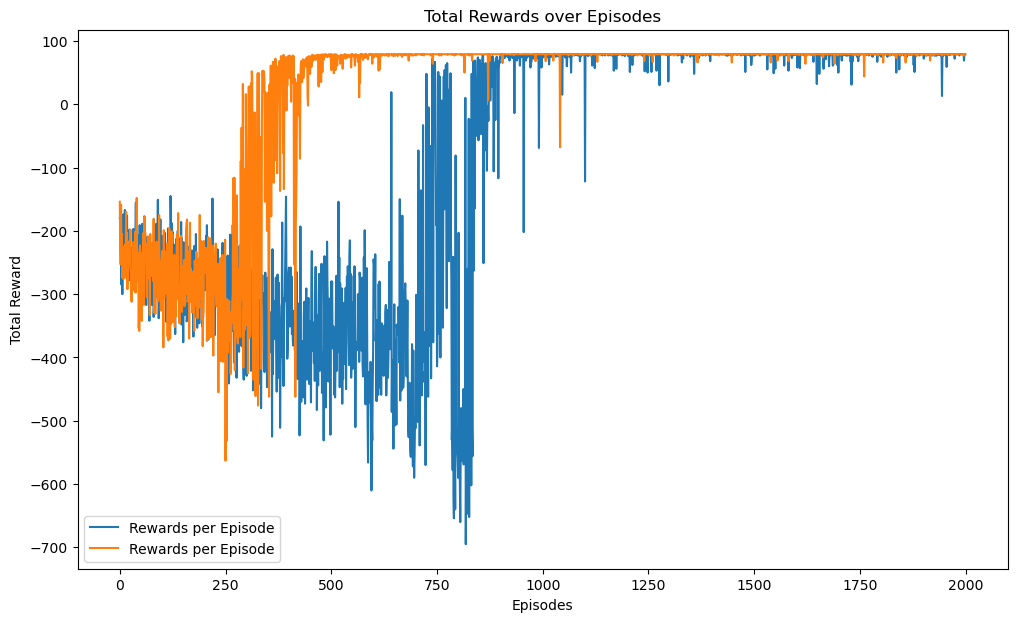

In [172]:
def plot_rewards(rewards1, rewards2):
    plt.figure(figsize=(12, 7))
    plt.plot(rewards1, label='Rewards per Episode')
    plt.plot(rewards2, label='Rewards per Episode')
    plt.xlabel('Episodes')
    plt.ylabel('Total Reward')
    plt.title('Total Rewards over Episodes')
    plt.legend()
    plt.show()

plot_rewards(rewards_Q, rewards_ATT)

Line appears at episode: 1139 for agent Q
Line appears at episode: 730 for agent Q+


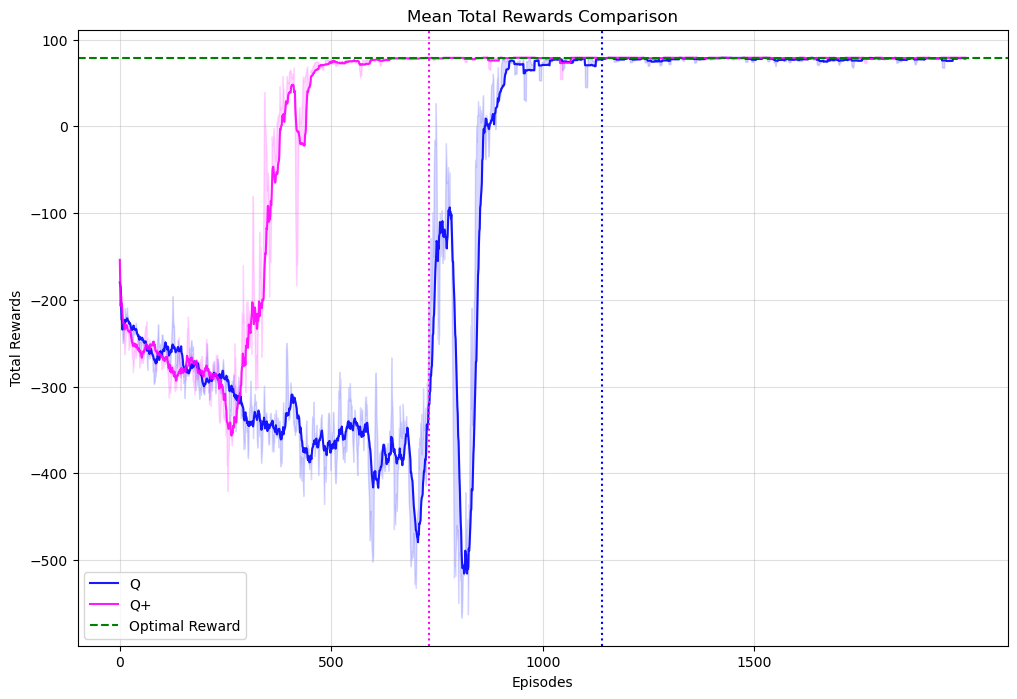

In [173]:
def plot_learning_curve(total_rewards_list, EPISODES, labels, colors, optimal_reward):
    fig, ax = plt.subplots(figsize=(12, 8))
    for i, total_rewards in enumerate(total_rewards_list):
        mean_rewards_1, mean_rewards_50 = np.zeros(EPISODES), np.zeros(EPISODES)
        for t in range(EPISODES):
            mean_rewards_1[t] = np.mean(total_rewards[max(0, t-5):(t+1)])
            mean_rewards_50[t] = np.mean(total_rewards[max(0, t-25):(t+1)])
        ax.plot(mean_rewards_50, label=f'{labels[i]}', alpha=0.9, color=colors[i])
        ax.fill_between(range(EPISODES), mean_rewards_1, mean_rewards_50, color=colors[i], alpha=0.15)
        # Check for 20 consecutive iterations with reward >= optimal reward
        for t in range(EPISODES - 10):
            if all(total_rewards[t:t+10] >= optimal_reward):
                ax.axvline(x=t+10, color=colors[i], linestyle='dotted')
                print(f"Line appears at episode: {t+10} for agent {labels[i]}")
                break
    ax.axhline(y=optimal_reward, color='green', linestyle='--', label='Optimal Reward')
    ax.legend()
    ax.grid(True, alpha=0.4)  # Add this line to enable gridlines
    plt.xlabel("Episodes")
    plt.xticks(np.arange(0, EPISODES, step=500))
    plt.ylabel("Total Rewards")
    plt.title("Mean Total Rewards Comparison")
    plt.show()
labels = ["Q", "Q+"]
colors = ["blue", "magenta"]
total_rewards_list = [total_Q, total_ATT]#, avg_total_rewards_AGENT_1_ATTENTION]
plot_learning_curve(total_rewards_list, EPISODES, labels, colors, optimal_reward=79)

In [183]:
def evaluate_policy(env, agent, verbose=True):
    state = env.reset()
    #state = ((4, 0), False)
    total_reward = 0
    collisions = []
    destroy = []
    done = False
    steps = 0
    cnt = 0
    cnt_dynamic = 0
    while not done:
        option = agent.select_option(state, exploration_rate=0)
        action = agent.select_action(state, option, exploration_rate=0)
        next_state, reward, done, _, _ = env.step(action, option)
        total_reward += reward
        if verbose:
            # Use termcolor for colored text
            option_text = colored(f"Option: {option}", "green")
            action_text = colored(f"Action: {action}", "blue")
            print(f"Step {steps}: || State={state} || {option_text} || {action_text} || Reward={reward} || Next State={next_state} || Done={done}")
        # state = next_state
        if next_state[0] in env.ditches:
            cnt += 1
            collisions.append(next_state[0])
        
        if next_state[0] in env.fires:
            cnt_dynamic += 1
            destroy.append(next_state[0])
        steps += 1
        state = next_state

    print(f"Total reward: {total_reward} | Steps Taken: {steps} with {cnt} collisions in {collisions} and {cnt_dynamic} drops in {destroy} | Success: {'Yes' if state[0] == env.finalState[0] and state[1] and state[4] else 'No'}\n")

evaluate_policy(env, agent_attention, verbose=True)

Step 0: || State=((4, 1), False, False, False, False) || Option: EXPLORE || Action: right || Reward=-1 || Next State=((4, 2), False, False, False, False) || Done=False
Step 1: || State=((4, 2), False, False, False, False) || Option: EXPLORE || Action: right || Reward=-1 || Next State=((4, 3), False, False, False, False) || Done=False
Step 2: || State=((4, 3), False, False, False, False) || Option: EXPLORE || Action: down || Reward=-1 || Next State=((5, 3), False, False, False, False) || Done=False
Step 3: || State=((5, 3), False, False, False, False) || Option: EXPLORE || Action: down || Reward=-1 || Next State=((6, 3), False, False, False, False) || Done=False
Step 4: || State=((6, 3), False, False, False, False) || Option: EXPLORE || Action: left || Reward=-1 || Next State=((6, 2), False, False, False, False) || Done=False
Step 5: || State=((6, 2), False, False, False, False) || Option: EXPLORE || Action: left || Reward=-1 || Next State=((6, 1), False, False, False, False) || Done=Fa

In [176]:
def visitation_heatmap(visit_counts, GRID):
    # Create a grid of visit counts from the dictionary
    grid_counts = np.zeros((GRID[0], GRID[1]))  # Assuming a 7x7 grid
    for state, count in visit_counts.items():
        grid_counts[state] = count
    # Create the heatmap
    fig, ax = plt.subplots(figsize=(14, 14))
    heatmap = ax.imshow(grid_counts, cmap='viridis', interpolation='nearest')
    # Add visitation counts to the cells
    for i in range(grid_counts.shape[0]):
        for j in range(grid_counts.shape[1]):
            count = grid_counts[i, j]

            ax.text(j, i, str(int(count)), ha='center', va='center', color='w', fontsize=8)
    # Add colorbar
    cbar = ax.figure.colorbar(heatmap, ax=ax)
    cbar.ax.set_ylabel('Visit Count', rotation=-90, va="bottom")
    # Set axis limits and labels
    ax.set_xlim([-0.5, grid_counts.shape[1] - 0.5])
    ax.set_ylim([grid_counts.shape[0] - 0.5, -0.5])
    ax.set_title('Visit Count Heatmap')
    ax.set_xlabel('Column')
    ax.set_ylabel('Row')
    # Set axis ticks to display numbers from 0 to 14
    ax.set_xticks(range(grid_counts.shape[1]))
    ax.set_yticks(range(grid_counts.shape[0]))
    # Set tick labels to 0-14
    ax.set_xticklabels(range(grid_counts.shape[1]))
    ax.set_yticklabels(range(grid_counts.shape[0]))
    plt.show()


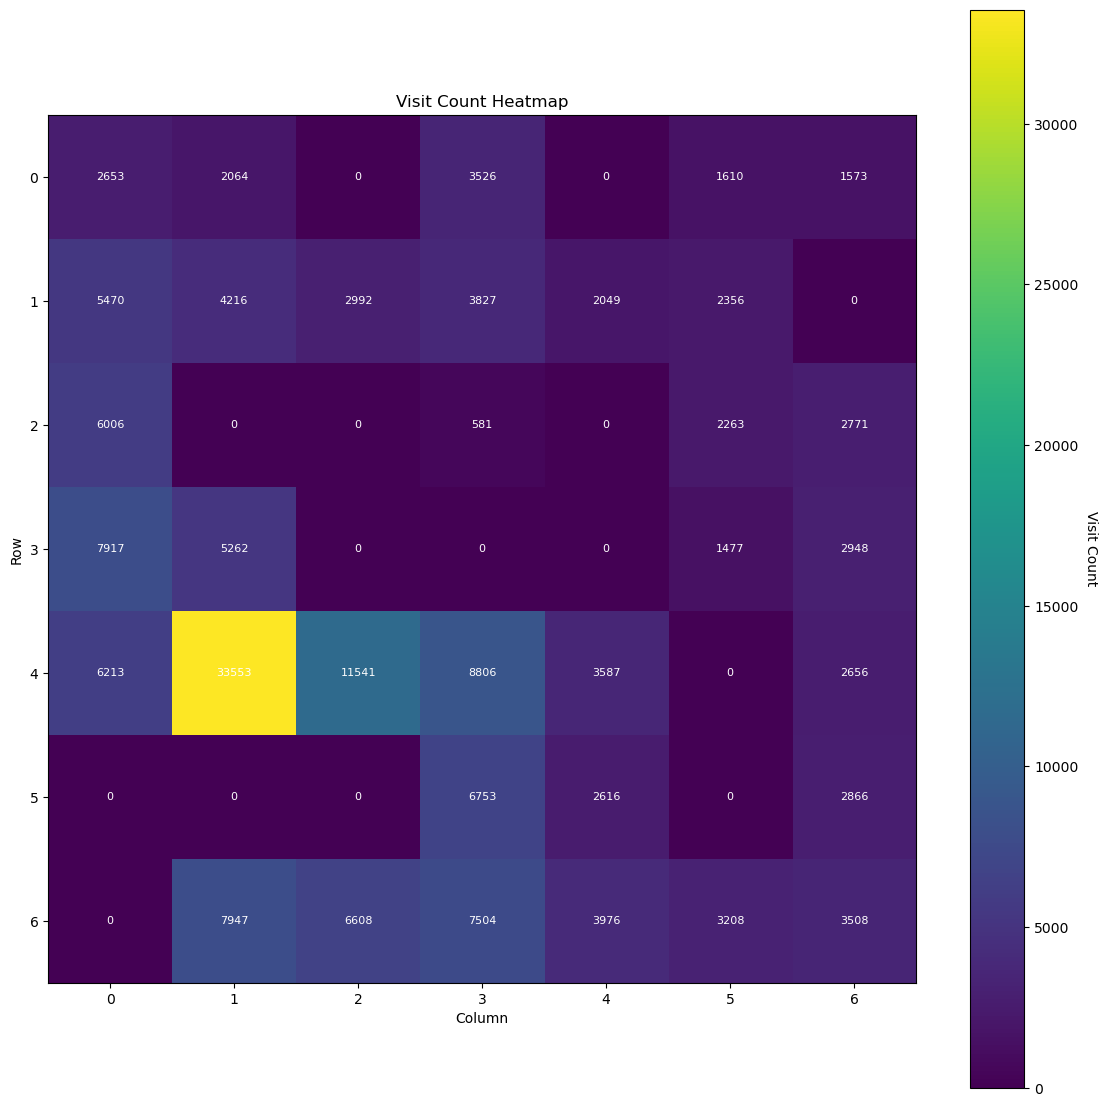

In [177]:
visitation_heatmap(visits_Q, env.gridsize)

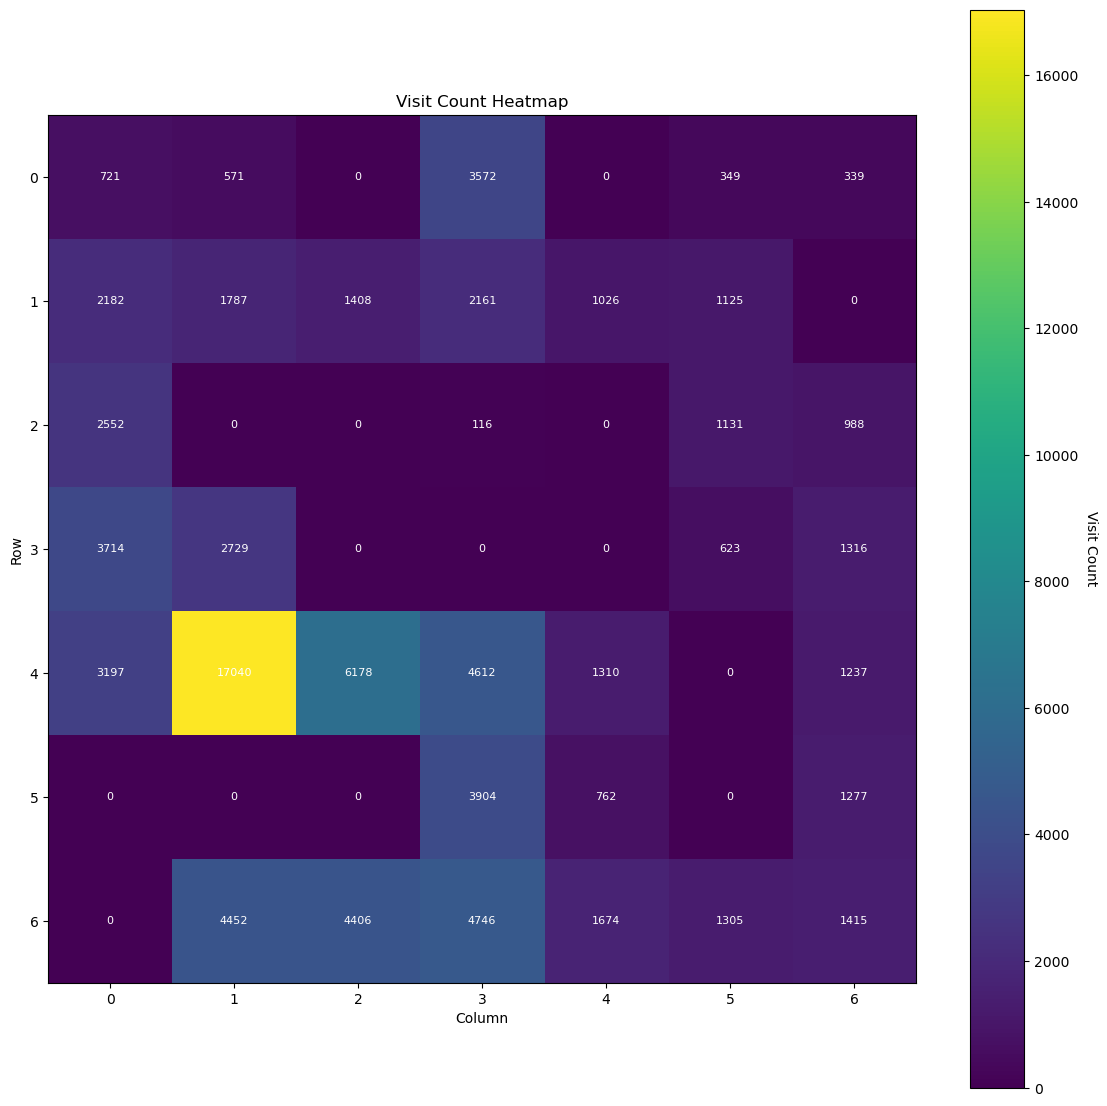

In [178]:
visitation_heatmap(visits_ATT, env.gridsize)